- competition/dataset : [https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)
- date : 2021/03/26
- original : [https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda)

## Stop the S@#$ - Toxic Comments EDA

**✏ 필사 1회** 

### Introduction
인터넷의 익명화가 때로는 사람들이 현실에서는 하지 않을 험악한 말들을 하게 만들 수 있습니다. 우리의 플랫폼에서 증오심을 걸러봅시다.

**Objective:**  
독설 분류를 위한 EDA와 feature-engineering  

**Data Overview:**  
이 대회의 데이터셋은 사람들이 악성에 대해 평가한 위키 말뭉치 데이터셋입니다. 2004~2015년 사이의 유저 페이지와 기사에 관한 토론으로부터 나온 6300만 개의 코멘트들을 포함합니다.  

플랫폼/사이트마다 악성 댓글 검사 절차에 있어 기준이 다를 수 있습니다. 이런 이유로 코멘트들은 다음과 같은 다섯 가지 카테고리로 태그되어 있습니다:  
* toxic (심한)
* severe_toxic (극심한)
* obsence (외설적인)
* threat (위협적인)
* insult (모욕적인)
* identity_hate

이 태깅은 crowdsourcing에 의해 수행되었으며, 이 데이터셋이 여러 사람들에 의해 평가되었고 태깅이 100% 정확도를 가지지 못할 것을 의미합니다. 이 부분에 대해 [이곳](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46131)에서 논의되고 있습니다.  

In [1]:
# import required packages
# basics
import pandas as pd
import numpy as np

# misc
import gc
import time
import warnings

# stats
from matplotlib.pyplot import imread
from scipy import sparse
import scipy.stats as ss

# viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Tweet tokenizer는 아포스트로피에서 분할x
from nltk.tokenize import TweetTokenizer

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# settings
start_time = time.time()
color = sns.color_palette()
sns.set_style('dark')
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline

In [2]:
# importing the dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# take a peak
train.tail(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [4]:
nrow_train = train.shape[0]
nrow_test = train.shape[0]
sum = nrow_train + nrow_test
print('      : train  : test')
print('rows  :', nrow_train, ':', nrow_test)
print('pers  :', round(nrow_train*100/sum), '    :', round(nrow_test*100/sum))

      : train  : test
rows  : 159571 : 159571
pers  : 50     : 50


이후에 train:test 비율을 30:70으로 나누고 테스트셋 바꿀 수 있습니다.  

트레이닝 셋에서 범주의 불균형에 대해 살펴봅시다.

#### Class Imbalance

In [6]:
# marking comments without any tags as 'clean'
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums == 0)

# count number of clean entries
print('Total comments =', len(train))
print('Total clean comments =', train['clean'].sum())
print('Total tags =', x.sum())

Total comments = 159571
Total clean comments = 143346
Total tags = 35098


In [10]:
print('Check for missing values in Train dataset')
print(train.isnull().sum())
print('Check for missing values in Test dataset')
print(test.isnull().sum())
print('filling NA with \'unknown\'')
train['comment_text'].fillna('unknown', inplace=True)
test['comment_text'].fillna('unknown', inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with 'unknown'


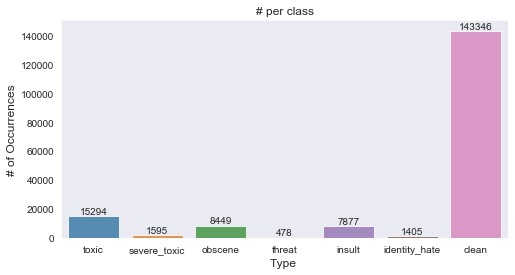

In [14]:
x = train.iloc[:, 2:].sum()

# plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('# per class')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')
plt.show()

- 악성은 클래스별로 고르게 퍼져있지 않습니다. 이런 이유로 클래스 불균형 문제를 만날 수 있습니다.  
- 트레이닝 데이터셋에는 ~95K개의 댓글들과 ~21K개의 태그, 그리고 ~86K개의 clean 댓글이 있습니다.  
    -> 이는 각 댓글이 여러 태그와 연결된 경우에만 가능합니다. 댓글은 크게 악성과 외설적인 댓글로 나눌 수 있습니다.

#### Multi-tagging
얼마나 많은 댓글들이 여러 개의 태그를 가지고 있는지 확인해봅시다.

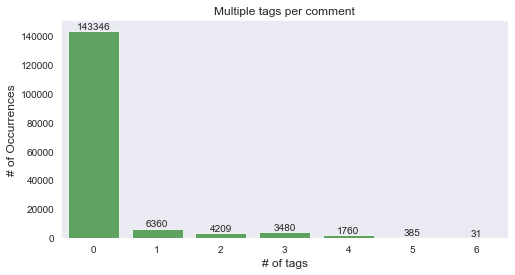

In [20]:
x = rowsums.value_counts()

# plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8, color=color[2])
plt.title('Multiple tags per comment')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')
plt.show()

전체의 ~10%의 댓글들만이 일종의 악성을 가지고 있습니다.

#### Which tags go together?
이제 어떤 태그들이 종종 함께 달리는지 확인해보겠습니다. 상관관계 플롯을 통해 나타내기 좋습니다.

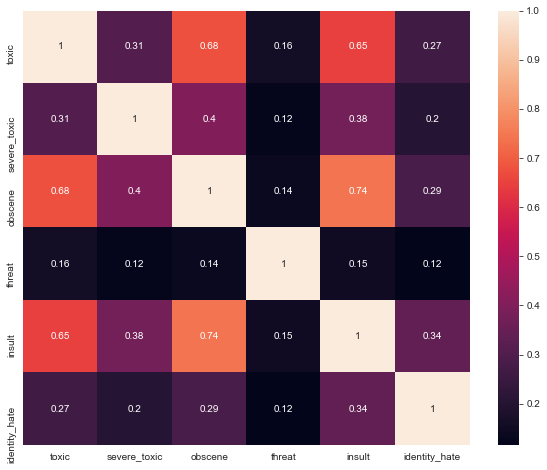

In [29]:
# clea comment는 지움
temp_df = train.iloc[:, 2:-1]

corr = temp_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)
plt.show()

위 플롯은 동시 발생 패턴을 나타내지만, pearson 상관관계를 사용하는 pandas의 기본 corr 함수는 범주형 변수이기 때문에 여기에 적용되지 않습니다. 따라서 두 범주형 변수 사이의 패턴을 파악하기 위해 다음과 같은 도구들을 사용할 수 있습니다:  
- Confusion matrix/Crosstab (혼동 행렬)  
- Cramer's V Statistics (Crammer의 V 계수)  
    Crammer의 V 계수는 카이제곱 검정의 확장으로, 연관성의 범위와 강도도 측정됩니다.

In [50]:
def highlight_min(data, color='yellow'):
    '''
    Series나 DataFrame의 최댓값 강조
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [51]:
# Crosstab
main_col = 'toxic'
corr_mats = []
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=temp_df.columns[1:])

# cell highlighting
out = out.style.apply(highlight_min, axis=0)
out

- 약간 악성(severe_toxic) 댓글은 항상 악성(toxic) 댓글입니다.  
- 다른 클래스들은 몇 가지 예외를 포함하는 toxic의 하위 집합으로 보입니다.

In [55]:
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    '''
    Cramer의 V 계수를 통해 범주형-범주형 간의 연관성 계산
    Wicher Bergsma의 상관관계 사용
    '''
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [56]:
# checking for Toxic and Severe Toxic for now
col1 = 'toxic'
col2 = 'severe_toxic'
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print('Confusion matrix between toxic and severe toxic:')
print(confusion_matrix)
new_corr = cramers_corrected_stat(confusion_matrix)
print('The correlation between Toxic and Severe toxic using Cramer\'s stat =', new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat = 0.30850290540548614


#### Example Comments:

In [57]:
print('toxic:')
print(train[train['severe_toxic'] == 1].iloc[3, 1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [58]:
print('severe_toxic:')
print(train[train['severe_toxic'] == 1].iloc[4, 1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [59]:
print('threat:')
print(train[train['threat'] == 1].iloc[1, 1])

threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [60]:
print('obscene:')
print(train[train['obscene'] == 1].iloc[1, 1])

obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [61]:
print('identity_hate:')
print(train[train['identity_hate'] == 1].iloc[4, 1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


- 일부 댓글들은 같은 내용을 복사하고 붙여넣은 것으로 보입니다.  
- 댓글에 여전히 IP 주소나 유저 이름, 문서 ID로 추정되는 번호들이 포함되어 있습니다.

### Wordclouds - Frequent words
클래스와 관계된 단어들을 살펴봅시다.  

Chart Desc: 여기에 funky pics로 워드클라우드를 만드는 좋은 방법이 나와 있습니다. 다음과 같은 단계를 통해 진행됩니다.  
```
- base64 인코딩된 이미지 검색  
- 셀에 인코딩을 붙여넣고, codecs 패키지를 사용하여 이미지로 변환
- 새로운 이미지를 마스크로 사용하여 워드클라우드 생성
```

In [63]:
stopword = set(STOPWORDS)

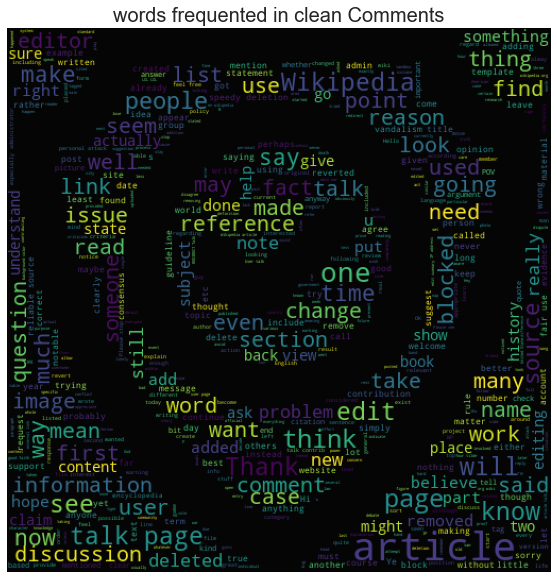

In [66]:
# clean comments
clean_mask = np.array(Image.open('data/safe-zone.png'))
clean_mask = clean_mask[:, :, 1]

# wordcloud for clean comments
subset = train[train['clean'] == True]
text = subset['comment_text'].values
wc = WordCloud(
    background_color='black', max_words=2000, mask=clean_mask, stopwords=stopword
)
wc.generate(' '.join(text))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.title('words frequented in clean Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=21), alpha=0.98)
plt.show()

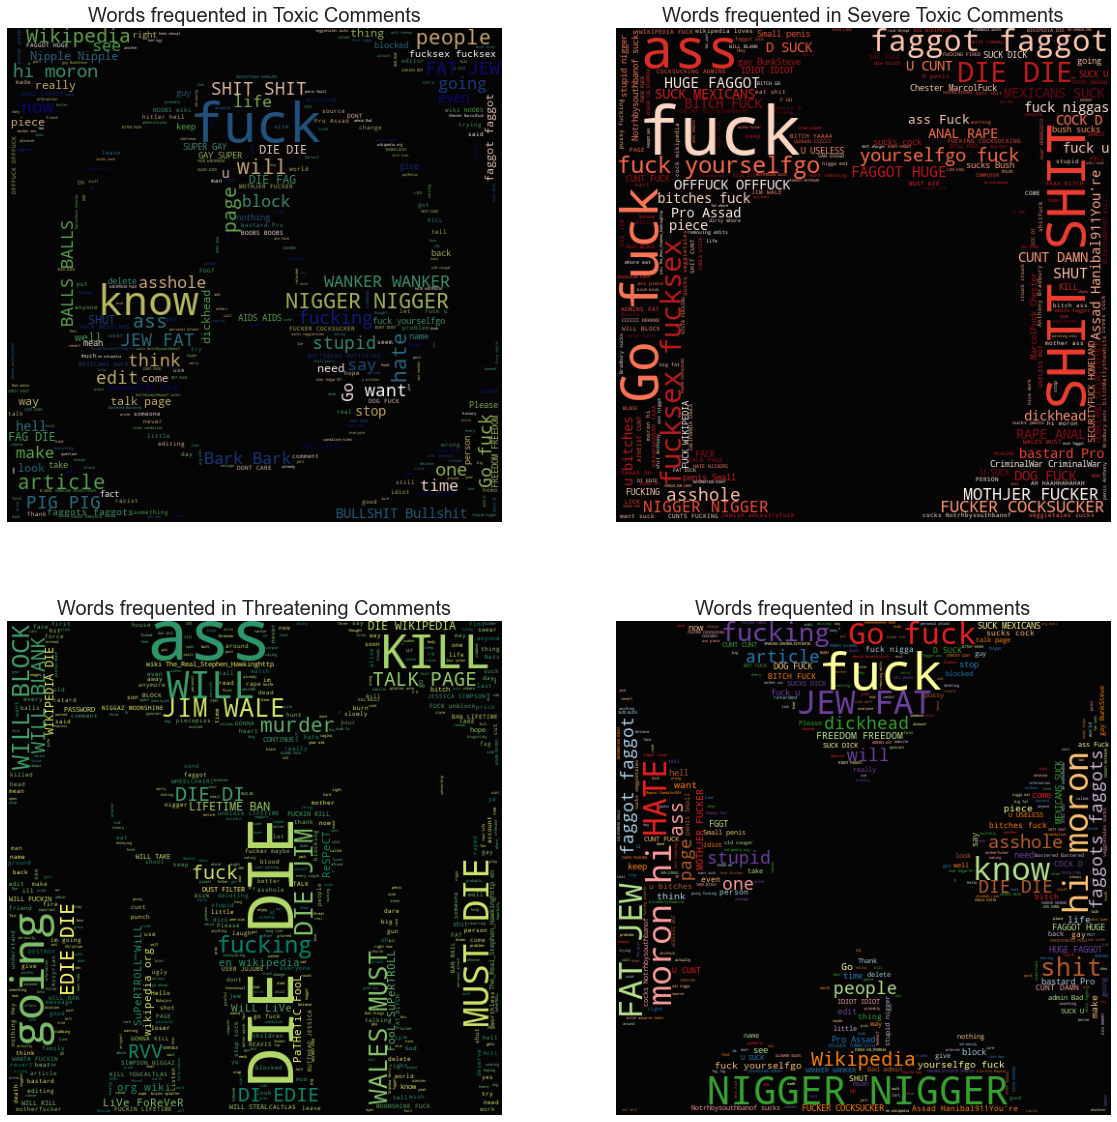

In [69]:
# wordcloud for toxic comments
toxic_mask = np.array(Image.open('data/toxic-sign.png'))
toxic_mask = toxic_mask[:, :, 1]
subset = train[train['toxic'] == 1]
text = subset['comment_text'].values
wc = WordCloud(
    background_color='black', max_words=2000, mask=toxic_mask, stopwords=stopword
)
wc.generate(' '.join(text))
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.axis('off')
plt.title('Words frequented in Toxic Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='gist_earth', random_state=21), alpha=0.98)

# wordcloud for severe toxic comments
severe_toxic_mask = np.array(Image.open('data/bomb.png'))
severe_toxic_mask = severe_toxic_mask[:, :, 1]
subset = train[train['severe_toxic'] == 1]
text = subset['comment_text'].values
wc = WordCloud(
    background_color='black', max_words=2000, mask=severe_toxic_mask, stopwords=stopword
)
wc.generate(' '.join(text))
plt.subplot(222)
plt.axis('off')
plt.title('Words frequented in Severe Toxic Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=21), alpha=0.98)

# wordcloud for threat comments
threat_mask = np.array(Image.open('data/anger.png'))
threat_mask = threat_mask[:, :, 1]
subset = train[train['threat'] == 1]
text = subset['comment_text'].values
wc = WordCloud(
    background_color='black', max_words=2000, mask=threat_mask, stopwords=stopword
)
wc.generate(' '.join(text))
plt.subplot(223)
plt.axis('off')
plt.title('Words frequented in Threatening Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='summer', random_state=21), alpha=0.98)

# wordcloud for insult comments
insult_mask = np.array(Image.open('data/swords.png'))
insult_mask = insult_mask[:, :, 1]
subset = train[train['insult'] == 1]
text = subset['comment_text'].values
wc = WordCloud(
    background_color='black', max_words=2000, mask=insult_mask, stopwords=stopword
)
wc.generate(' '.join(text))
plt.subplot(224)
plt.axis('off')
plt.title('Words frequented in Insult Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='Paired_r', random_state=21), alpha=0.98)

plt.show()

### Feature engineering:
feature engineering 아이디어를 크게 세 가지 그룹으로 나누었습니다.  

**Direct features:**  
